In [1]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

## Training data

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [5]:
# Error voxels
indices_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [6]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indices_beginning_0_all] = 0

In [7]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [8]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

In [9]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals_all_100206)

In [58]:
np.max(S0_100206)

26293.4794921875

In [58]:
normalized_scan_100206 = scan_100206_long_no_background / S0_100206

In [17]:
len(np.where(S0_100206 < 100)[0])

609

In [18]:
big_b_indices_100206 = np.where(bvals_all_100206 != 0.005)[0]

In [20]:
bvals_100206 = bvals_all_100206[big_b_indices_100206]

In [61]:
normalized_scan_100206_no_b5 = normalized_scan_100206[:, big_b_indices_100206]

In [62]:
normalized_scan_100206_no_b5.shape

(935442, 270)

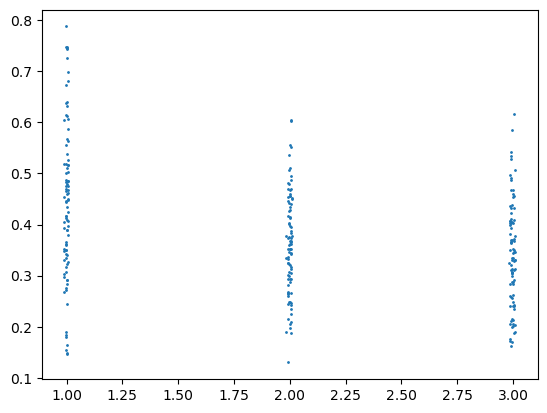

In [128]:
plt.plot(bvals_100206, normalized_scan_100206_no_b5[42,:], "o", markersize = 1)

In [121]:
np.where(bvals_all_100206 == 0.99)[0].shape

(11,)

In [59]:
np.unique(bvals_all_100206)

array([0.005, 0.99 , 0.995, 1.   , 1.005, 1.985, 1.99 , 1.995, 2.   ,
       2.005, 2.01 , 2.98 , 2.985, 2.99 , 2.995, 3.   , 3.005, 3.01 ])

In [93]:
print(len(np.where(bvals_all_100206 == 0.005)[0]))
print("1000 threshold")
print(len(np.where(bvals_all_100206 == 0.99)[0]))
print(len(np.where(bvals_all_100206 == 0.995)[0]))
print(len(np.where(bvals_all_100206 == 1.)[0]))
print(len(np.where(bvals_all_100206 == bvals_all_100206[26])[0]))
print("2000 threshold")
print(len(np.where(bvals_all_100206 == 1.985)[0]))
print(len(np.where(bvals_all_100206 == 1.99)[0]))
print(len(np.where(bvals_all_100206 == 1.995)[0]))
print(len(np.where(bvals_all_100206 == 2.)[0]))
print(len(np.where(bvals_all_100206 == 2.005)[0]))
print("3000 threshold")
print(len(np.where(bvals_all_100206 == bvals_all_100206[104])[0]))
print(len(np.where(bvals_all_100206 == 2.98)[0]))
print(len(np.where(bvals_all_100206 == 2.985)[0]))
print(len(np.where(bvals_all_100206 == 2.99)[0]))
print(len(np.where(bvals_all_100206 == 2.995)[0]))
print(len(np.where(bvals_all_100206 == 3.)[0]))
print(len(np.where(bvals_all_100206 == 3.005)[0]))
print(len(np.where(bvals_all_100206 == bvals_all_100206[19])[0]))

18
1000 threshold
11
33
25
21
2000 threshold
3
21
14
21
28
3000 threshold
3
1
14
20
17
15
15
8


In [74]:
np.where(bvals_all_100206 == 2.995)

(array([  5,  12,  15,  47,  51,  67, 102, 105, 130, 150, 156, 185, 189,
        198, 217, 234, 241]),)

In [92]:
bvals_all_100206[19]

3.0100000000000002

In [82]:
bvals_all_100206[104]

2.0100000000000002

In [46]:
np.save("normalized_scan_100206_no_b5.npy",normalized_scan_100206_no_b5)

In [12]:
normalized_scan_100206_no_b5 = np.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/normalised_data/normalized_scan_100206_no_b5.npy")

## Neural Network

In [13]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [14]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [15]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [102]:
n_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n_100206 = n_all_100206[:,big_b_indices_100206].T
print(n_100206.shape)

b_values_100206 = torch.FloatTensor(bvals_100206)
gradient_directions_100206 = torch.FloatTensor(n_100206)

net = BallStickNet(gradient_directions_100206, b_values_100206)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

(270, 3)


In [42]:
batch_size = 128
num_batches = len(normalized_scan_100206_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [43]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:38<00:00, 74.40it/s]


Loss: 1478.4545322875492
Average Loss: 0.20230631257355627
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:48<00:00, 67.36it/s]


Loss: 427.47736691311
Average Loss: 0.058494439916955396
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:55<00:00, 63.32it/s]


Loss: 424.3274536007084
Average Loss: 0.058063417296210784
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [02:06<00:00, 57.71it/s]


Loss: 422.27268549986184
Average Loss: 0.057782250342071954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [02:02<00:00, 59.55it/s]


Loss: 422.39098119409755
Average Loss: 0.057798437492350516
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 1


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:52<00:00, 64.79it/s]


Loss: 421.2576895994134
Average Loss: 0.05764336201415071
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:17<00:00, 94.76it/s]


Loss: 421.109392802231
Average Loss: 0.057623069622636976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:13<00:00, 99.83it/s]


Loss: 420.4216143595986
Average Loss: 0.05752895653524885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.51it/s]


Loss: 420.153600981459
Average Loss: 0.05749228256451273
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 107.70it/s]


Loss: 419.7648778408766
Average Loss: 0.05743909111123106
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|▉                                                         | 116/7308 [00:04<01:11, 101.06it/s]

X_batch: 
torch.Size([128, 270])
tensor([[0.4030, 0.3139, 0.2764,  ..., 0.5451, 0.4096, 0.3128],
        [0.2946, 0.0903, 0.1469,  ..., 0.2539, 0.1585, 0.1603],
        [0.4869, 0.3587, 0.0681,  ..., 0.4843, 0.2886, 0.2884],
        ...,
        [0.3778, 0.1346, 0.2162,  ..., 0.2939, 0.2727, 0.2480],
        [0.5772, 0.1821, 0.2527,  ..., 0.5821, 0.2548, 0.1834],
        [0.4033, 0.2069, 0.1400,  ..., 0.4021, 0.2098, 0.1304]])
X_pred: 
torch.Size([128, 270])
tensor([[0.5007, 0.3318, 0.2298,  ..., 0.4871, 0.3381, 0.2558],
        [0.2791, 0.1376, 0.0961,  ..., 0.2686, 0.1416, 0.0990],
        [0.4907, 0.2846, 0.1824,  ..., 0.4758, 0.2905, 0.1879],
        ...,
        [0.4290, 0.2467, 0.1701,  ..., 0.4128, 0.2525, 0.1728],
        [0.4731, 0.2634, 0.1689,  ..., 0.4599, 0.2675, 0.1680],
        [0.4105, 0.2016, 0.1220,  ..., 0.4021, 0.2015, 0.1186]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.26it/s]


Loss: 419.74905825033784
Average Loss: 0.05743692641630239
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [02:03<00:00, 59.05it/s]


Loss: 419.5813190820627
Average Loss: 0.05741397360181482
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:32<00:00, 79.35it/s]


Loss: 419.39017852861434
Average Loss: 0.057387818627341866
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:37<00:00, 74.60it/s]


Loss: 419.25262116640806
Average Loss: 0.05736899578084401
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [02:09<00:00, 56.51it/s]


Loss: 418.1849705004133
Average Loss: 0.05722290236732531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:20<00:00, 90.32it/s]


Loss: 418.2162220112514
Average Loss: 0.05722717870980451
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 1


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:35<00:00, 76.16it/s]


Loss: 418.27596349688247
Average Loss: 0.05723535351626744
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 2


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:36<00:00, 75.69it/s]


Loss: 417.8259167233482
Average Loss: 0.05717377076126823
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:53<00:00, 64.47it/s]


Loss: 417.1382525311783
Average Loss: 0.05707967330749566
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:56<00:00, 62.47it/s]


Loss: 417.5920491050929
Average Loss: 0.05714176917146865
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 112.25it/s]


Loss: 417.314946468221
Average Loss: 0.05710385145980036
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.08it/s]


Loss: 416.83270876668394
Average Loss: 0.05703786381591187
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.82it/s]


Loss: 417.1310349400155
Average Loss: 0.05707868567871039
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.29it/s]


Loss: 417.04212317359634
Average Loss: 0.057066519317678754
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.74it/s]


Loss: 416.5766711276956
Average Loss: 0.0570028285615347
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.13it/s]


Loss: 416.5561063904315
Average Loss: 0.057000014558077655
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.95it/s]


Loss: 416.3205171725713
Average Loss: 0.05696777739088277
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.64it/s]


Loss: 416.9680324634537
Average Loss: 0.05705638101579826
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.83it/s]


Loss: 416.3820704042446
Average Loss: 0.05697620011004989
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.25it/s]


Loss: 416.4393284772523
Average Loss: 0.056984035095409453
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.83it/s]


Loss: 416.3072980600409
Average Loss: 0.05696596853585672
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.25it/s]


Loss: 416.2425011321902
Average Loss: 0.056957101961164505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.64it/s]


Loss: 416.12437380850315
Average Loss: 0.05694093785009622
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.00it/s]


Loss: 415.90284575498663
Average Loss: 0.05691062476121875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.27it/s]


Loss: 416.0885690995492
Average Loss: 0.05693603846463454
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.69it/s]


Loss: 415.541770366719
Average Loss: 0.05686121652527627
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 110.97it/s]


Loss: 414.7646816682536
Average Loss: 0.05675488254902211
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 101.44it/s]


Loss: 413.432866479503
Average Loss: 0.05657264182806555
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:38<00:00, 74.17it/s]


Loss: 411.6216190021951
Average Loss: 0.0563247973456753
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:39<00:00, 73.81it/s]


Loss: 411.557785615325
Average Loss: 0.05631606261840791
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:25<00:00, 85.43it/s]


Loss: 411.60975312558
Average Loss: 0.05632317366250411
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.80it/s]


Loss: 411.44472800404765
Average Loss: 0.05630059222824954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.91it/s]


Loss: 410.99108993960544
Average Loss: 0.0562385180541332
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.22it/s]


Loss: 410.26014061807655
Average Loss: 0.05613849762152115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.53it/s]


Loss: 410.28762088739313
Average Loss: 0.056142257921099226
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.04it/s]


Loss: 409.6838169437833
Average Loss: 0.05605963559712415
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.90it/s]


Loss: 409.3015610773582
Average Loss: 0.05600732910199209
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.24it/s]


Loss: 409.6087374573108
Average Loss: 0.05604936199470591
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.32it/s]


Loss: 408.64334538555704
Average Loss: 0.0559172612733384
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 166.00it/s]


Loss: 408.5801564573776
Average Loss: 0.05590861473144192
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.19it/s]


Loss: 408.29335017409176
Average Loss: 0.055869369208277474
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.79it/s]


Loss: 408.12866394012235
Average Loss: 0.05584683414615796
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.44it/s]


Loss: 408.0314730829559
Average Loss: 0.05583353490461904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.80it/s]


Loss: 407.4816331237089
Average Loss: 0.05575829681495743
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.63it/s]


Loss: 407.28749139024876
Average Loss: 0.055731731169984776
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.63it/s]


Loss: 407.35710764769465
Average Loss: 0.055741257204118044
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.17it/s]


Loss: 407.02772586932406
Average Loss: 0.05569618580587357
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.84it/s]


Loss: 407.1319781956263
Average Loss: 0.055710451313030415
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.68it/s]


Loss: 406.68361046235077
Average Loss: 0.05564909831176119
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.19it/s]


Loss: 406.5504503173288
Average Loss: 0.05563087716438544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.91it/s]


Loss: 406.6118911628146
Average Loss: 0.05563928450503757
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.76it/s]


Loss: 406.2453605621122
Average Loss: 0.05558912979777123
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.67it/s]


Loss: 406.51789843221195
Average Loss: 0.05562642288344444
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.08it/s]


Loss: 406.1299320019316
Average Loss: 0.05557333497563377
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.27it/s]


Loss: 406.0802016837988
Average Loss: 0.05556653006072781
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.44it/s]


Loss: 405.8621807731688
Average Loss: 0.05553669687645988
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.31it/s]


Loss: 406.01045940979384
Average Loss: 0.05555698678294935
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.62it/s]


Loss: 405.7771832605358
Average Loss: 0.05552506612760479
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.76it/s]


Loss: 406.0681384957861
Average Loss: 0.05556487937818639
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.47it/s]


Loss: 405.3077189240139
Average Loss: 0.05546082634428214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.51it/s]


Loss: 405.6826576446183
Average Loss: 0.05551213158793354
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.74it/s]


Loss: 405.65283221472055
Average Loss: 0.05550805038515607
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.81it/s]


Loss: 405.2917866753414
Average Loss: 0.05545864623362636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.65it/s]


Loss: 406.10603932780214
Average Loss: 0.055570065589463896
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.77it/s]


Loss: 405.3871028525755
Average Loss: 0.055471688950817666
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.39it/s]


Loss: 405.456209232565
Average Loss: 0.05548114521518405
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.25it/s]


Loss: 405.1252612960525
Average Loss: 0.055435859509585725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.68it/s]


Loss: 405.51361044007353
Average Loss: 0.05548899978654537
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.53it/s]


Loss: 405.20919035817496
Average Loss: 0.055447344055579495
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.80it/s]


Loss: 404.93131809611805
Average Loss: 0.05540932103121484
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.68it/s]


Loss: 404.85575964068994
Average Loss: 0.05539898188843595
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.92it/s]


Loss: 405.1489841004368
Average Loss: 0.05543910565140076
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.82it/s]


Loss: 404.91906067403033
Average Loss: 0.05540764377039276
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.87it/s]


Loss: 405.0801769190002
Average Loss: 0.05542969032827042
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.01it/s]


Loss: 404.88362788106315
Average Loss: 0.055402795276554895
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.60it/s]


Loss: 404.65572054008953
Average Loss: 0.05537160926930618
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.03it/s]


Loss: 404.9393869882915
Average Loss: 0.05541042514891783
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.28it/s]


Loss: 404.81450990680605
Average Loss: 0.055393337425671325
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.62it/s]


Loss: 404.6315563523676
Average Loss: 0.05536830273020903
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.40it/s]


Loss: 404.7079767314717
Average Loss: 0.05537875981547232
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.22it/s]


Loss: 404.39817314525135
Average Loss: 0.05533636742545859
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.64it/s]


Loss: 404.94300240068696
Average Loss: 0.05541091986873111
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.94it/s]


Loss: 404.45765309454873
Average Loss: 0.05534450644424586
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.31it/s]


Loss: 404.8506591957994
Average Loss: 0.05539828396220572
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.55it/s]


Loss: 404.45592604391277
Average Loss: 0.05534427012095139
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.01it/s]


Loss: 404.28583971690387
Average Loss: 0.055320996129844535
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.67it/s]


Loss: 404.48538310360163
Average Loss: 0.05534830091729634
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.82it/s]


Loss: 404.68387713842094
Average Loss: 0.055375462115273805
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.13it/s]


Loss: 404.35200635320507
Average Loss: 0.055330050130433094
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.85it/s]


Loss: 404.4935552456882
Average Loss: 0.05534941916333993
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.66it/s]


Loss: 404.2436867649667
Average Loss: 0.055315228074023906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.96it/s]


Loss: 404.0670869827736
Average Loss: 0.05529106280552458
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.69it/s]


Loss: 404.36814857367426
Average Loss: 0.05533225897286183
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.11it/s]


Loss: 404.7095511944499
Average Loss: 0.05537897525922959
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.80it/s]


Loss: 404.16974483500235
Average Loss: 0.05530511013067903
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.54it/s]


Loss: 404.17159836390056
Average Loss: 0.055305363760796464
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.38it/s]


Loss: 404.39828796172515
Average Loss: 0.05533638313652506
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.71it/s]


Loss: 404.1152264100965
Average Loss: 0.05529765002874884
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.59it/s]


Loss: 404.13570249965414
Average Loss: 0.055300451901977854
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.53it/s]


Loss: 404.1556133921258
Average Loss: 0.055303176435704135
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.76it/s]


Loss: 404.25351587613113
Average Loss: 0.05531657305365779
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 9


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.09it/s]


Loss: 404.00742669962347
Average Loss: 0.05528289911051224
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.52it/s]


Loss: 403.73725168872625
Average Loss: 0.05524592934985307
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.04it/s]


Loss: 403.6896458445117
Average Loss: 0.055239415140190436
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.97it/s]


Loss: 404.05518602160737
Average Loss: 0.055289434321511684
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.87it/s]


Loss: 403.7254670399707
Average Loss: 0.055244316781605185
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.88it/s]


Loss: 403.7891366733238
Average Loss: 0.05525302910144004
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.61it/s]


Loss: 404.0319861189928
Average Loss: 0.05528625973166294
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.29it/s]


Loss: 404.16643994417973
Average Loss: 0.05530465790150243
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.64it/s]


Loss: 403.72058305400424
Average Loss: 0.055243648474822694
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.18it/s]


Loss: 403.78329444420524
Average Loss: 0.0552522296721682
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 169.96it/s]


Loss: 403.97964415862225
Average Loss: 0.055279097449182024
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.14it/s]


Loss: 403.9398869960569
Average Loss: 0.05527365722441939
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 9


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.06it/s]


Loss: 403.6854149326682
Average Loss: 0.05523883619768311
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.21it/s]


Loss: 403.58172701019794
Average Loss: 0.055224647921483024
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.05it/s]


Loss: 404.0738514312543
Average Loss: 0.055291988427922045
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.25it/s]


Loss: 403.55291475658305
Average Loss: 0.05522070535804366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.40it/s]


Loss: 403.57611739914864
Average Loss: 0.055223880322817276
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.19it/s]


Loss: 403.67893931712024
Average Loss: 0.05523795009812811
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.83it/s]


Loss: 403.6824736802373
Average Loss: 0.055238433727454475
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.82it/s]


Loss: 403.8445581726264
Average Loss: 0.0552606127767688
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.32it/s]


Loss: 403.8312196643092
Average Loss: 0.05525878758405982
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.94it/s]


Loss: 403.5412462865934
Average Loss: 0.05521910868727331
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.09it/s]


Loss: 403.383313234197
Average Loss: 0.05519749770582882
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.53it/s]


Loss: 403.5365168333519
Average Loss: 0.0552184615261839
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.84it/s]


Loss: 403.4595179054886
Average Loss: 0.05520792527442373
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.44it/s]


Loss: 403.2926514400169
Average Loss: 0.05518509187739695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.54it/s]


Loss: 403.4806714025326
Average Loss: 0.055210819841616396
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.10it/s]


Loss: 403.48308364581317
Average Loss: 0.0552111499241671
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.84it/s]


Loss: 403.28649154049344
Average Loss: 0.055184248979268394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.12it/s]


Loss: 403.4370017738547
Average Loss: 0.05520484424929594
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.39it/s]


Loss: 403.5075498879887
Average Loss: 0.055214497795291285
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.47it/s]


Loss: 403.21245521097444
Average Loss: 0.05517411811863361
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.73it/s]


Loss: 403.3351829345338
Average Loss: 0.05519091173160014
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.82it/s]


Loss: 403.2138667423278
Average Loss: 0.05517431126742307
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.21it/s]


Loss: 403.4654331372585
Average Loss: 0.05520873469311145
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.09it/s]


Loss: 403.2083954256959
Average Loss: 0.05517356259245976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.83it/s]


Loss: 403.23458549845964
Average Loss: 0.055177146346258844
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.20it/s]


Loss: 403.3016611561179
Average Loss: 0.05518632473400628
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.14it/s]


Loss: 403.13593102712184
Average Loss: 0.05516364682910808
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.00it/s]


Loss: 402.9091228717007
Average Loss: 0.05513261123039145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.69it/s]


Loss: 403.1606910023838
Average Loss: 0.05516703489359385
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.47it/s]


Loss: 403.2007143103983
Average Loss: 0.05517251153672664
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.27it/s]


Loss: 403.1901042535901
Average Loss: 0.05517105969534621
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.03it/s]


Loss: 403.02985577774234
Average Loss: 0.055149131879822434
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.58it/s]


Loss: 403.2736243598629
Average Loss: 0.055182488281316756
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.66it/s]


Loss: 403.1569828512147
Average Loss: 0.055166527483745856
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.14it/s]


Loss: 403.14071961375885
Average Loss: 0.05516430208179514
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.48it/s]


Loss: 402.8653658241965
Average Loss: 0.055126623675998424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.92it/s]


Loss: 402.80992092820816
Average Loss: 0.05511903679915273
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.86it/s]


Loss: 402.97729476494715
Average Loss: 0.05514193962300864
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.58it/s]


Loss: 402.9578119406942
Average Loss: 0.05513927366457228
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.00it/s]


Loss: 403.0675388730597
Average Loss: 0.05515428829680619
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.46it/s]


Loss: 402.9105742513202
Average Loss: 0.05513280983187195
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.57it/s]


Loss: 402.85677146934904
Average Loss: 0.05512544765590436
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.05it/s]


Loss: 402.95015144953504
Average Loss: 0.05513822543097086
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.58it/s]


Loss: 402.9657389600761
Average Loss: 0.0551403583689212
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 169.98it/s]


Loss: 402.8772779549472
Average Loss: 0.05512825368841642
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.28it/s]


Loss: 403.040307901334
Average Loss: 0.05515056211019896
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 9


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.05it/s]


Loss: 402.6664401241578
Average Loss: 0.05509940341053063
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.64it/s]


Loss: 402.8717453384306
Average Loss: 0.055127496625401014
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.87it/s]


Loss: 402.91142871580087
Average Loss: 0.055132926753667336
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.10it/s]


Loss: 402.86386364139616
Average Loss: 0.05512641812279641
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.87it/s]


Loss: 402.8045102765318
Average Loss: 0.055118296425360126
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.69it/s]


Loss: 402.9220959248487
Average Loss: 0.055134386415551274
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.61it/s]


Loss: 403.03119515720755
Average Loss: 0.05514931515561132
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.20it/s]


Loss: 402.84072631876916
Average Loss: 0.05512325209616436
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.75it/s]


Loss: 402.93214354431257
Average Loss: 0.055135761295061925
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.24it/s]


Loss: 402.6328729914967
Average Loss: 0.05509481020682768
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.99it/s]


Loss: 402.7648887448013
Average Loss: 0.05511287475982503
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.90it/s]


Loss: 402.5810923175886
Average Loss: 0.05508772472873408
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.51it/s]


Loss: 402.815026398981
Average Loss: 0.05511973541310632
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.06it/s]


Loss: 402.50292881624773
Average Loss: 0.055077029120997226
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.36it/s]


Loss: 402.6105696938466
Average Loss: 0.05509175830512406
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.36it/s]


Loss: 402.8742164291907
Average Loss: 0.05512783476042566
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.40it/s]


Loss: 402.89764448837377
Average Loss: 0.05513104057038502
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.39it/s]


Loss: 402.64901747507975
Average Loss: 0.055097019358932645
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.21it/s]


Loss: 402.60342926578596
Average Loss: 0.05509078123505555
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.82it/s]


Loss: 402.7669491302222
Average Loss: 0.0551131566954327
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.16it/s]


Loss: 402.52388943056576
Average Loss: 0.0550798972948229
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.89it/s]


Loss: 402.8096780204214
Average Loss: 0.05511900356053933
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.37it/s]


Loss: 402.61158586107194
Average Loss: 0.055091897353731795
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 9


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.34it/s]

Loss: 402.63889914611354
Average Loss: 0.05509563480379222
Done, best loss: 402.50292881624773
Done


<All keys matched successfully>

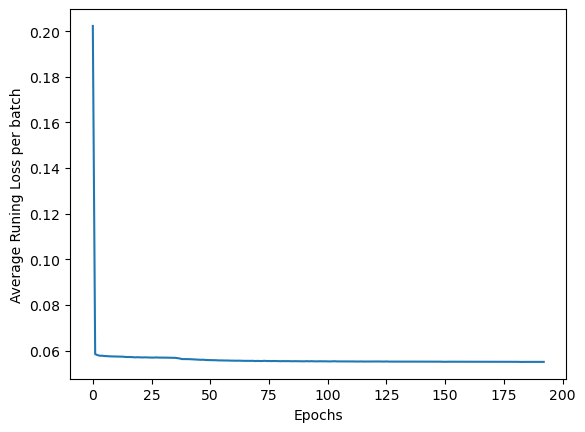

In [44]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [45]:
torch.save(final_model, 'model_100206_norm_01_Feb_182e.pt')

## Load saved NN

In [21]:
n_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n_100206 = n_all_100206[:,big_b_indices_100206].T
print(n_100206.shape)

b_values_100206 = torch.FloatTensor(bvals_100206)
gradient_directions_100206 = torch.FloatTensor(n_100206)

(270, 3)


In [22]:
net_100206 = BallStickNet(gradient_directions_100206, b_values_100206)
net_100206.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_norm_01_Feb_182e.pt"))
net_100206.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=5, bias=True)
  )
)

## Inference

In [23]:
X_100206_pred, mu_cart_100206_pred, lambda_par_100206_pred, lambda_iso_100206_pred,  volume_0_100206_pred, volume_1_100206_pred = net_100206(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)))

In [24]:
torch.where(volume_0_100206_pred >= 0.9)[0]

tensor([   423,    473,   1083,  ..., 933797, 934730, 934749])

In [25]:
volume_0_100206_pred[93379]

tensor([0.3480], grad_fn=<SelectBackward0>)

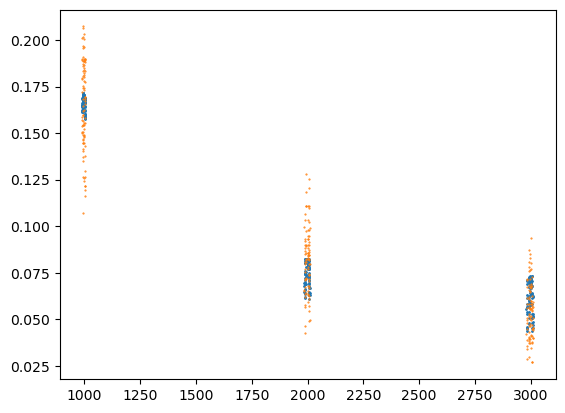

In [28]:
plt.plot(bvals_100206*1e03, X_100206_pred[12342,:].detach().numpy(),  "o", markersize = 1)
plt.plot(bvals_100206*1e03,normalized_scan_100206_no_b5[12342,:], ".", markersize = 1)

In [132]:
torch.max(X_100206_pred[42,:])

tensor(0.4535, grad_fn=<MaxBackward1>)

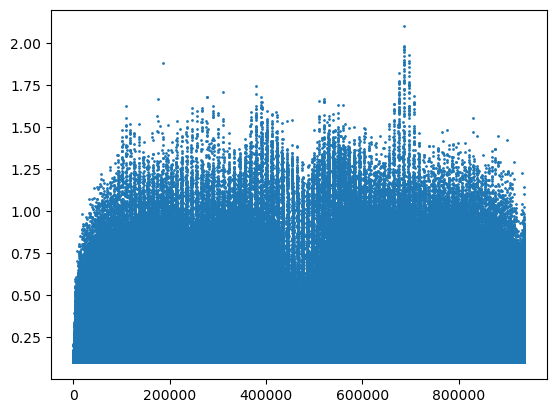

In [84]:
plt.plot(lambda_par_100206_pred.detach().numpy(), 'o', markersize  = 1)

## Restore predictions to 3D

In [32]:
def add_bg(mask_long, params):
    resume_params = np.copy(mask_long)
    no_bg_indices = np.where(mask_long == 1)[0]
    for i, index in enumerate(no_bg_indices):
        resume_params[index] = params[i]
    return resume_params

def back_to_3D(mask_long, parames_1d, shape):
    params_with_bg = add_bg(mask_long, parames_1d.detach().numpy())
    params_3d = np.reshape(params_with_bg, shape)
    return params_3d

In [33]:
lambda_par_100206_pred_3d = back_to_3D(mask_100206_long_pro, lambda_par_100206_pred, (145, 174, 145))
lambda_iso_100206_pred_3d = back_to_3D(mask_100206_long_pro, lambda_iso_100206_pred, (145, 174, 145))
volume_0_100206_pred_3d = back_to_3D(mask_100206_long_pro, volume_0_100206_pred, (145, 174, 145))
volume_1_100206_pred_3d = back_to_3D(mask_100206_long_pro, volume_1_100206_pred, (145, 174, 145))

## Dmipy fitting method

In [29]:
def get_acquisition_scheme(bvals, gradient_directions):
    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

In [30]:
def get_fitted_parameters(scan_slice, mask_slice, bvals, gradient_directions):
    scheme = get_acquisition_scheme(bvals, gradient_directions)
    
    ball = gaussian_models.G1Ball()
    stick = cylinder_models.C1Stick()
    BAS_mod = MultiCompartmentModel(models=[stick, ball])
    
    BAS_fit = BAS_mod.fit(scheme, scan_slice, mask_slice)
    
    return BAS_fit.fitted_parameters

In [31]:
fitted_parameters_100206_slice = get_fitted_parameters(scan_100206[:, 100, :, :], mask_100206[:,100,:], bvals_all_100206*1e9, n_all_100206.T)

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.
Setup brute2fine optimizer in 0.19501590728759766 seconds
Fitting of 8433 voxels complete in 221.77458715438843 seconds.
Average of 0.026298421339308483 seconds per voxel.


In [37]:
fitted_parameters_100206_slice.keys()

dict_keys(['C1Stick_1_mu', 'C1Stick_1_lambda_par', 'G1Ball_1_lambda_iso', 'partial_volume_0', 'partial_volume_1'])

In [99]:
predicted_signal_intensity_slice = BAS_fit_hcp.predict(scheme_hcp, fitted_parameters_100206_slice, mask_100206[:,100,:])

NameError: name 'BAS_fit_hcp' is not defined

In [96]:
fitted_parameters_100206_slice.get('partial_volume_0').shape

(145, 145)

In [98]:
lambda_par_100206_pred_3d[:,100,:].shape

(145, 145)

## Parameter maps

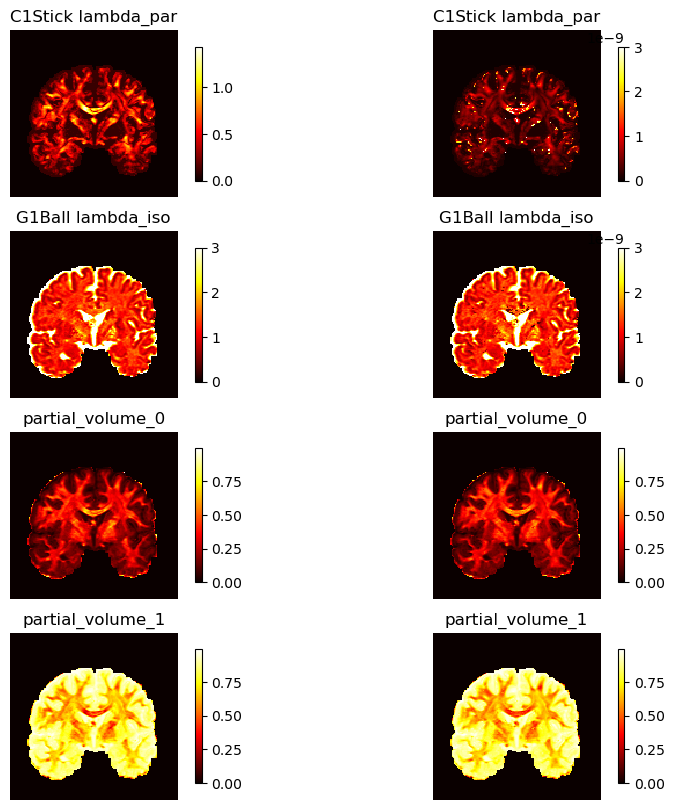

In [50]:
fig_100206, axs_100206 = plt.subplots(4, 2, figsize=[10, 10])
axs_100206 = axs_100206.ravel()

print_parameter_maps(fig_100206, axs_100206,
                     lambda_par_100206_pred_3d[:,100,:],
                     lambda_iso_100206_pred_3d[:,100,:],
                     volume_0_100206_pred_3d[:,100,:],
                     volume_1_100206_pred_3d[:,100,:],
                     fitted_parameters_100206_slice)

# speed of diffusivity
# image show pair

In [51]:
def print_parameter_maps2(fig, axs, lambda_par_nn_pred_slice,lambda_iso_nn_pred_slice,volume_0_nn_pred_slice,volume_1_nn_pred_slice,fitted_parameters):
    cf = axs[0].imshow(lambda_par_100206_pred_3d[:,100,:].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
    axs[0].set_title("C1Stick lambda_par")
    axs[0].set_axis_off()
    fig.colorbar(cf, ax=axs[0], shrink=0.8)
    
    show_mi(fig, axs, 1, fitted_parameters.get("C1Stick_1_lambda_par"),"C1Stick lambda_par")
    
    show_mi(fig, axs, 2, lambda_iso_nn_pred_slice,"G1Ball lambda_iso")
    
    show_mi(fig, axs, 3, fitted_parameters.get("G1Ball_1_lambda_iso"),"G1Ball lambda_iso")
    
    show_mi(fig, axs, 4, volume_0_nn_pred_slice,"partial_volume_0")
    
    show_mi(fig, axs, 5, fitted_parameters.get("partial_volume_0"),"partial_volume_0")
    
    show_mi(fig, axs, 6, volume_1_nn_pred_slice,"partial_volume_1")
    
    show_mi(fig, axs, 7, fitted_parameters.get("partial_volume_1"),"partial_volume_1")

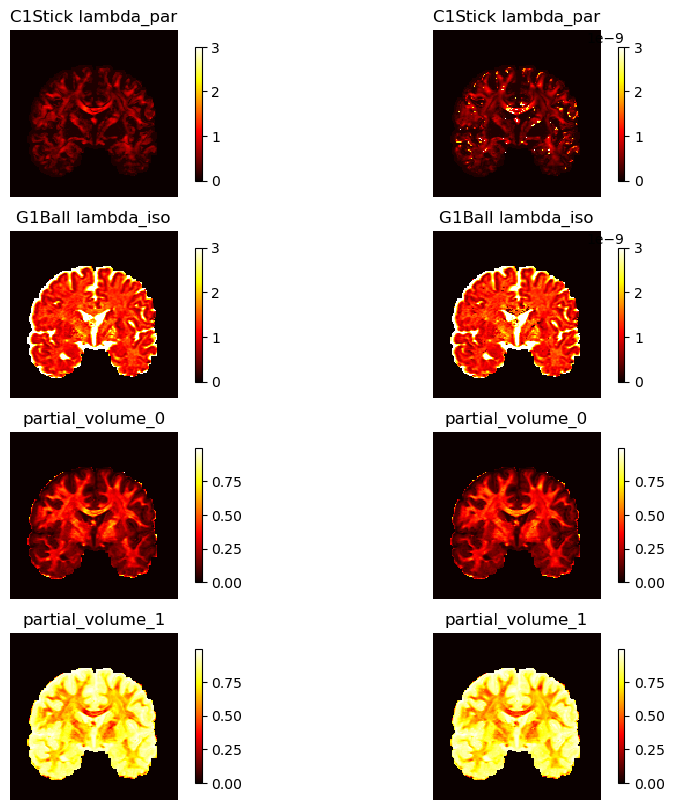

In [55]:
fig_100206_, axs_100206_ = plt.subplots(4, 2, figsize=[10, 10])
axs_100206_ = axs_100206_.ravel()

print_parameter_maps2(fig_100206_, axs_100206_,
                     lambda_par_100206_pred_3d[:,100,:],
                     lambda_iso_100206_pred_3d[:,100,:],
                     volume_0_100206_pred_3d[:,100,:],
                     volume_1_100206_pred_3d[:,100,:],
                     fitted_parameters_100206_slice)

## Testing data

In [2]:
scan_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/data.nii.gz')
mask_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/nodif_brain_mask.nii.gz')

In [4]:
scan_100307_dimension = scan_100307.shape
x = scan_100307_dimension[0]
y = scan_100307_dimension[1]
z = scan_100307_dimension[2]
b = scan_100307_dimension[3]

In [9]:
scan_100307_long = np.reshape(scan_100307, (x*y*z, b))

In [10]:
mask_100307_long = np.reshape(mask_100307, (x*y*z, 1))

In [11]:
# Error voxels
indices_beginning_0_all_100307 = np.where(scan_100307_long[:, 0] == 0)[0]

In [12]:
mask_100307_long_pro = np.copy(mask_100307_long)
mask_100307_long_pro[indices_beginning_0_all_100307] = 0

In [13]:
scan_100307_long_no_background = process_data.remove_background(scan_100307_long, mask_100307_long_pro)

In [14]:
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals') * 1e-3

In [15]:
S0_100307 = process_data.get_S0(scan_100307_long_no_background, bvals_all_100307)

In [16]:
normalized_scan_100307 = scan_100307_long_no_background / S0_100307

In [17]:
big_b_indices_100307 = np.where(bvals_all_100307 != 0.005)[0]

In [18]:
bvals_100307 = bvals_all_100307[big_b_indices_100307]

In [19]:
normalized_scan_100307_no_b5 = normalized_scan_100307[:, big_b_indices_100307]

In [20]:
normalized_scan_100307_no_b5.shape

(740145, 270)

In [22]:
n_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvecs')
n_100307 = n_all_100307[:,big_b_indices_100307].T
print(n_100307.shape)

b_values_100307 = torch.FloatTensor(bvals_100307)
gradient_directions_100307 = torch.FloatTensor(n_100307)

(270, 3)


In [29]:
net_100307 = BallStickNet(gradient_directions_100307, b_values_100307)
net_100307.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_norm_01_Feb_182e.pt"))
net_100307.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=5, bias=True)
  )
)

In [30]:
X_100307_pred, mu_cart__100307_pred_train, lambda_par_100307_pred_train, lambda_iso_100307_pred_train,  volume_0__100307_pred_train, volume_1__100307_pred_train = net_100307(torch.from_numpy(normalized_scan_100307_no_b5.astype(np.float32)))

In [100]:
print(volume_1__100307_pred_train.shape)
print(mu_cart__100307_pred_train.shape)

torch.Size([740145, 1])
torch.Size([3, 740145])


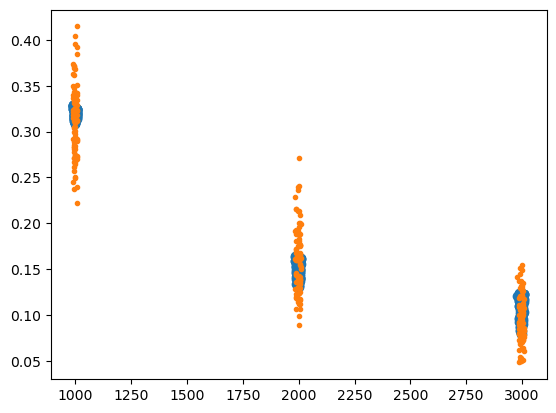

In [34]:
plt.plot(bvals_100307*1e03, X_100307_pred[1010,:].detach().numpy(),  "o")
plt.plot(bvals_100307*1e03,normalized_scan_100307_no_b5[1010,:], ".")

In [40]:
fitted_params_100307 = get_fitted_parameters(scan_100307[:, 100, :, :], mask_100307[:, 100, :], bvals_all_100307*1e9, n_all_100307.T)

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.
Setup brute2fine optimizer in 0.28487610816955566 seconds
Fitting of 7465 voxels complete in 225.24117493629456 seconds.
Average of 0.03017296382267844 seconds per voxel.


In [42]:
import matplotlib

In [46]:
def show_mi(fig, axs, idx, data_slice, title):
    cf = axs[idx].imshow(data_slice.squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
    axs[idx].set_title(title)
    axs[idx].set_axis_off()
    fig.colorbar(cf, ax=axs[idx], shrink=0.8)

In [49]:
def print_parameter_maps(fig, axs, lambda_par_nn_pred_slice,lambda_iso_nn_pred_slice,volume_0_nn_pred_slice,volume_1_nn_pred_slice,fitted_parameters):
    show_mi(fig, axs, 0, lambda_par_nn_pred_slice, "C1Stick lambda_par")
    
    show_mi(fig, axs, 1, fitted_parameters.get("C1Stick_1_lambda_par"),"C1Stick lambda_par")
    
    show_mi(fig, axs, 2, lambda_iso_nn_pred_slice,"G1Ball lambda_iso")
    
    show_mi(fig, axs, 3, fitted_parameters.get("G1Ball_1_lambda_iso"),"G1Ball lambda_iso")
    
    show_mi(fig, axs, 4, volume_0_nn_pred_slice,"partial_volume_0")
    
    show_mi(fig, axs, 5, fitted_parameters.get("partial_volume_0"),"partial_volume_0")
    
    show_mi(fig, axs, 6, volume_1_nn_pred_slice,"partial_volume_1")
    
    show_mi(fig, axs, 7, fitted_parameters.get("partial_volume_1"),"partial_volume_1")

In [98]:
lambda_par_pred_3d_100307 = back_to_3D(mask_100307_long_pro, lambda_par_100307_pred_train, (145, 174, 145))
lambda_iso_pred_3d_100307 = back_to_3D(mask_100307_long_pro, lambda_iso_100307_pred_train, (145, 174, 145))
volume_0_pred_3d_100307 = back_to_3D(mask_100307_long_pro, volume_0__100307_pred_train, (145, 174, 145))
volume_1_pred_3d_100307 = back_to_3D(mask_100307_long_pro, volume_1__100307_pred_train, (145, 174, 145))

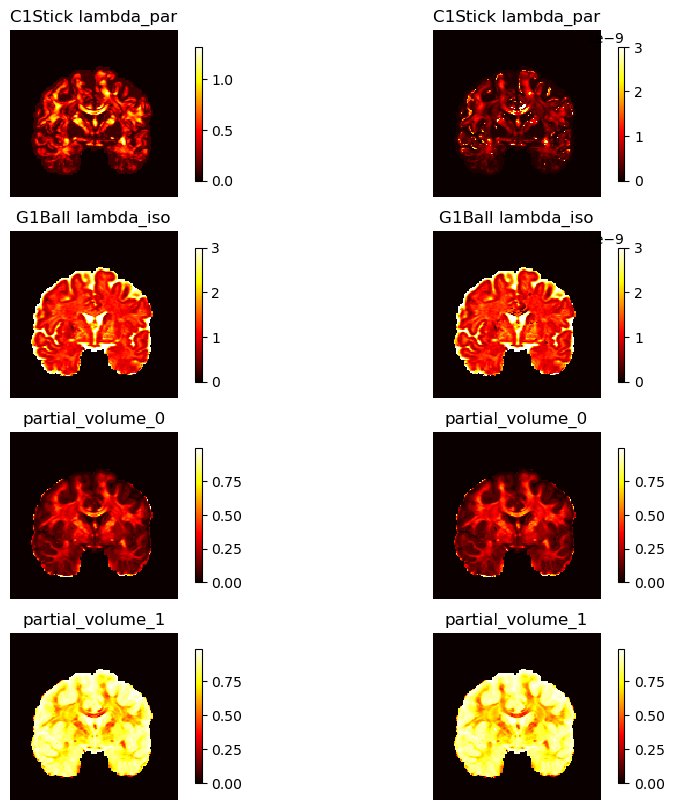

In [99]:
fig_test, axs_test = plt.subplots(4, 2, figsize=[10, 10])
axs_test = axs_test.ravel()

print_parameter_maps(fig_test, axs_test,
                     lambda_par_pred_3d_100307[:,100,:],
                     lambda_iso_pred_3d_100307[:,100,:],
                     volume_0_pred_3d_100307[:,100,:],
                     volume_1_pred_3d_100307[:,100,:],
                     fitted_params_100307)